#**Load 102 Category Flower Dataset**

In [1]:
!wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
!wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz'

--2024-12-28 21:40:11--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2024-12-28 21:40:13--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  18.4MB/s    in 21s     

2024-12-28 21:40:34 (15.9 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2024-12-28 21:40:34--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmenta

### Extract tar file

In [2]:
import tarfile

flowers_tgz = '102flowers.tgz'        # Path to the first file
segmentations_tgz = '102segmentations.tgz'  # Path to the second file

def extract_tgz(tgz_file, extract_path='./'):
    with tarfile.open(tgz_file, 'r:gz') as tar:
        print(f"Extracting: {tgz_file}")
        tar.extractall(path=extract_path)  # Extract all files to the specified path
        print(f"Extraction of {tgz_file} complete.")

# Extract both files
extract_tgz(flowers_tgz, './102flowers')        # Extract the 102flowers.tgz to a folder
extract_tgz(segmentations_tgz, './102segmentations')  # Extract the 102segmentations.tgz to a folder


Extracting: 102flowers.tgz
Extraction of 102flowers.tgz complete.
Extracting: 102segmentations.tgz
Extraction of 102segmentations.tgz complete.


### Import Libraries

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

### Set paths to the extracted directories

In [4]:
image_dir = './102flowers/jpg'
mask_dir = './102segmentations/segmim'

### Function to load images and their corresponding masks

In [5]:
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_name, mask_name in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0

        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

### Load and preprocess the data

In [6]:
images, masks = load_data(image_dir, mask_dir)

### Convert masks to categorical (for multi-class segmentation)
### Assuming binary segmentation (flower vs. background)
### Binary mask: 1 for flower, 0 for background

In [7]:
masks = np.where(masks > 0.5, 1, 0)

### Split data into training and testing sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


# Define the U-Net model

In [9]:
def Unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u3 = layers.UpSampling2D((2, 2))(u2)
    u3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u3)  # Sigmoid for binary segmentation

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

### compile the U-Net model


In [10]:
model = Unet(input_shape=(128, 128, 3))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,008,769 (26.74 MB)

 Trainable params: 7,008,769 (26.74 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=10)


Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 118s 217ms/step - accuracy: 0.8462 - loss: 0.3575 - val_accuracy: 0.9188 - val_loss: 0.1834
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 91s 152ms/step - accuracy: 0.9155 - loss: 0.1929 - val_accuracy: 0.9266 - val_loss: 0.1679
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - accuracy: 0.9255 - loss: 0.1705 - val_accuracy: 0.9315 - val_loss: 0.1575
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 81s 151ms/step - accuracy: 0.9291 - loss: 0.1621 - val_accuracy: 0.9349 - val_loss: 0.1498
Epoch 5/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 82s 151ms/step - accuracy: 0.9312 - loss: 0.1601 - val_accuracy: 0.9363 - val_loss: 0.1479
Epoch 6/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 82s 151ms/step - accuracy: 0.9358 - loss: 0.1487 - val_accuracy: 0.9379 - val_loss: 0.1404
Epoch 7/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - accuracy: 0.9377 - loss: 0.1445 - val_accuracy: 0.9330 - val_loss: 0.1537
Epoch 8/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 81s 151ms/step - accuracy: 0.9379 - loss: 

### Plot training history

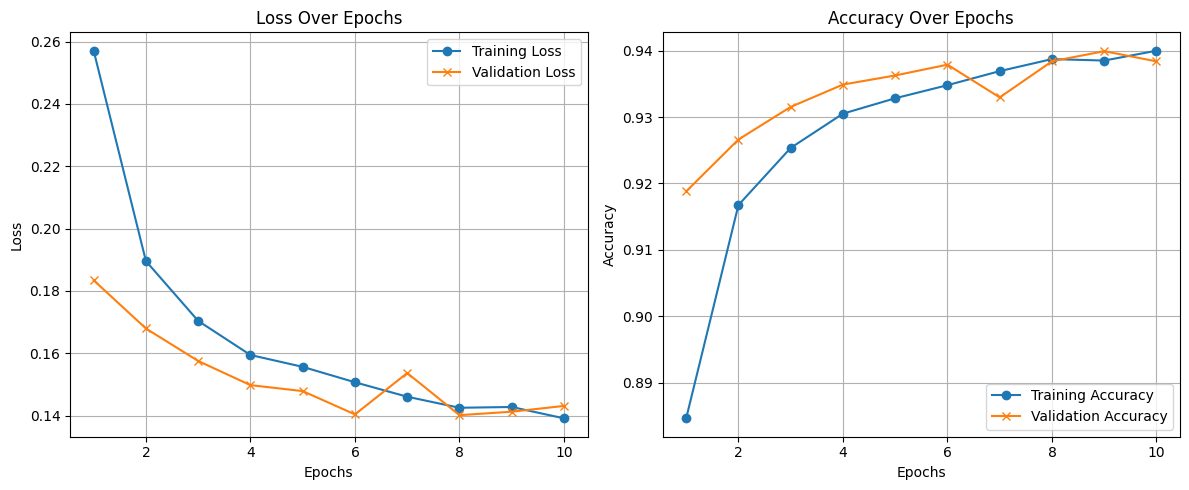

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Visualize some results

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


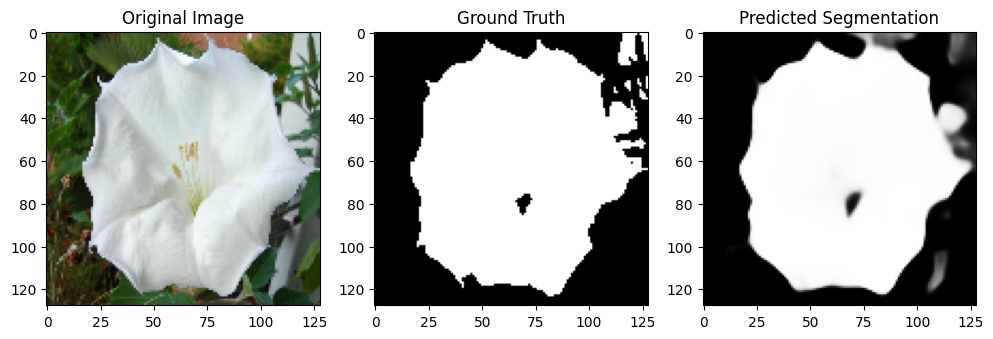

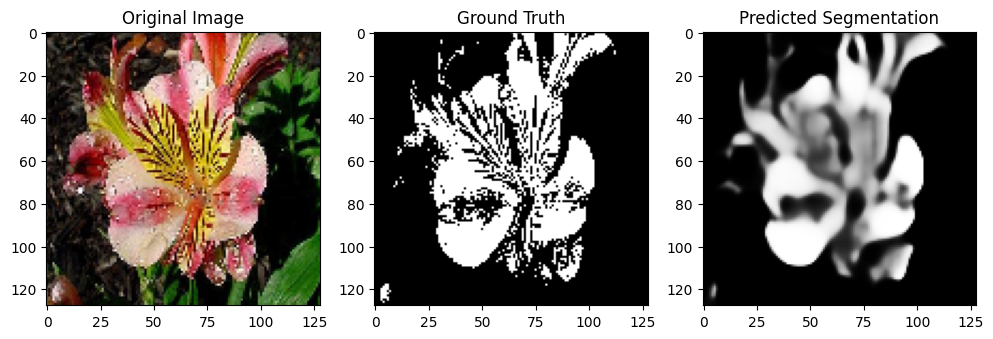

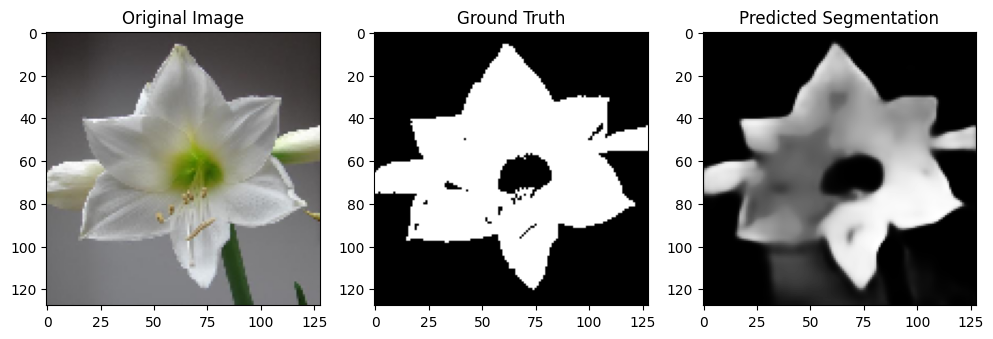

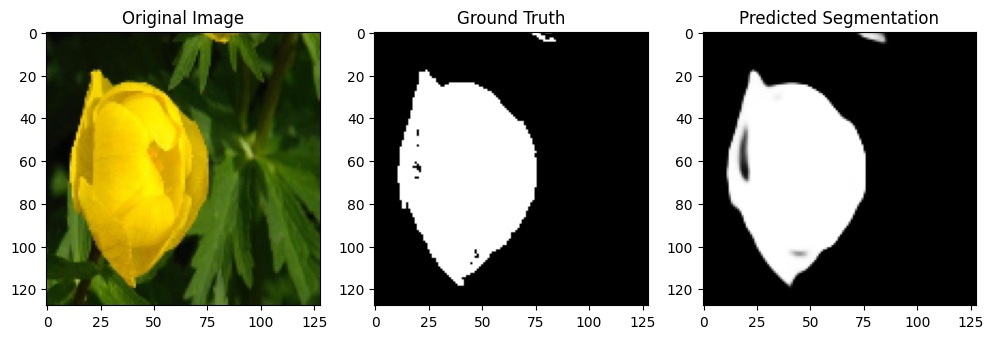

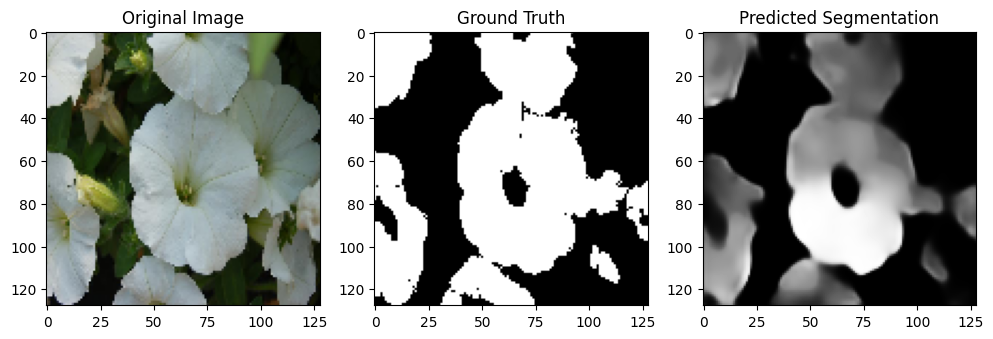

In [13]:
predictions = model.predict(X_test[:5])

for i in range(5):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title('Original Image')

    # Ground truth segmentation
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i], cmap='gray')
    plt.title('Ground Truth')

    # Predicted segmentation
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title('Predicted Segmentation')

    plt.show()